##Import e style

In [167]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from glob import glob
import shutil
from collections import defaultdict
import os
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

#Formattazione grafica
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
#####

RANDOM_SEED = 42   #Replicare l'esperimento
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Importa dataser



In [134]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2022-07-07 13:09:01--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip.1’

GTSRB_Final_Trainin 100%[===================>] 263.50M   109MB/s    in 2.4s    

2022-07-07 13:09:03 (109 MB/s) - ‘GTSRB_Final_Training_Images.zip.1’ saved [276294756/276294756]

replace GTSRB/Final_Training/Images/00000/00000_00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### Exploration 


In [135]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*')) #glob restituisce i path che corrispondono
print("Classi:")
len(train_folders)

Classi:


43


CSV funzioni visualizzazione immagini

In [136]:
#Carica immagine
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)    #conversione BGR a RBG 

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

#Mostra immagine
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

#Mostra griglia di immagini
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Sample per ogni classe

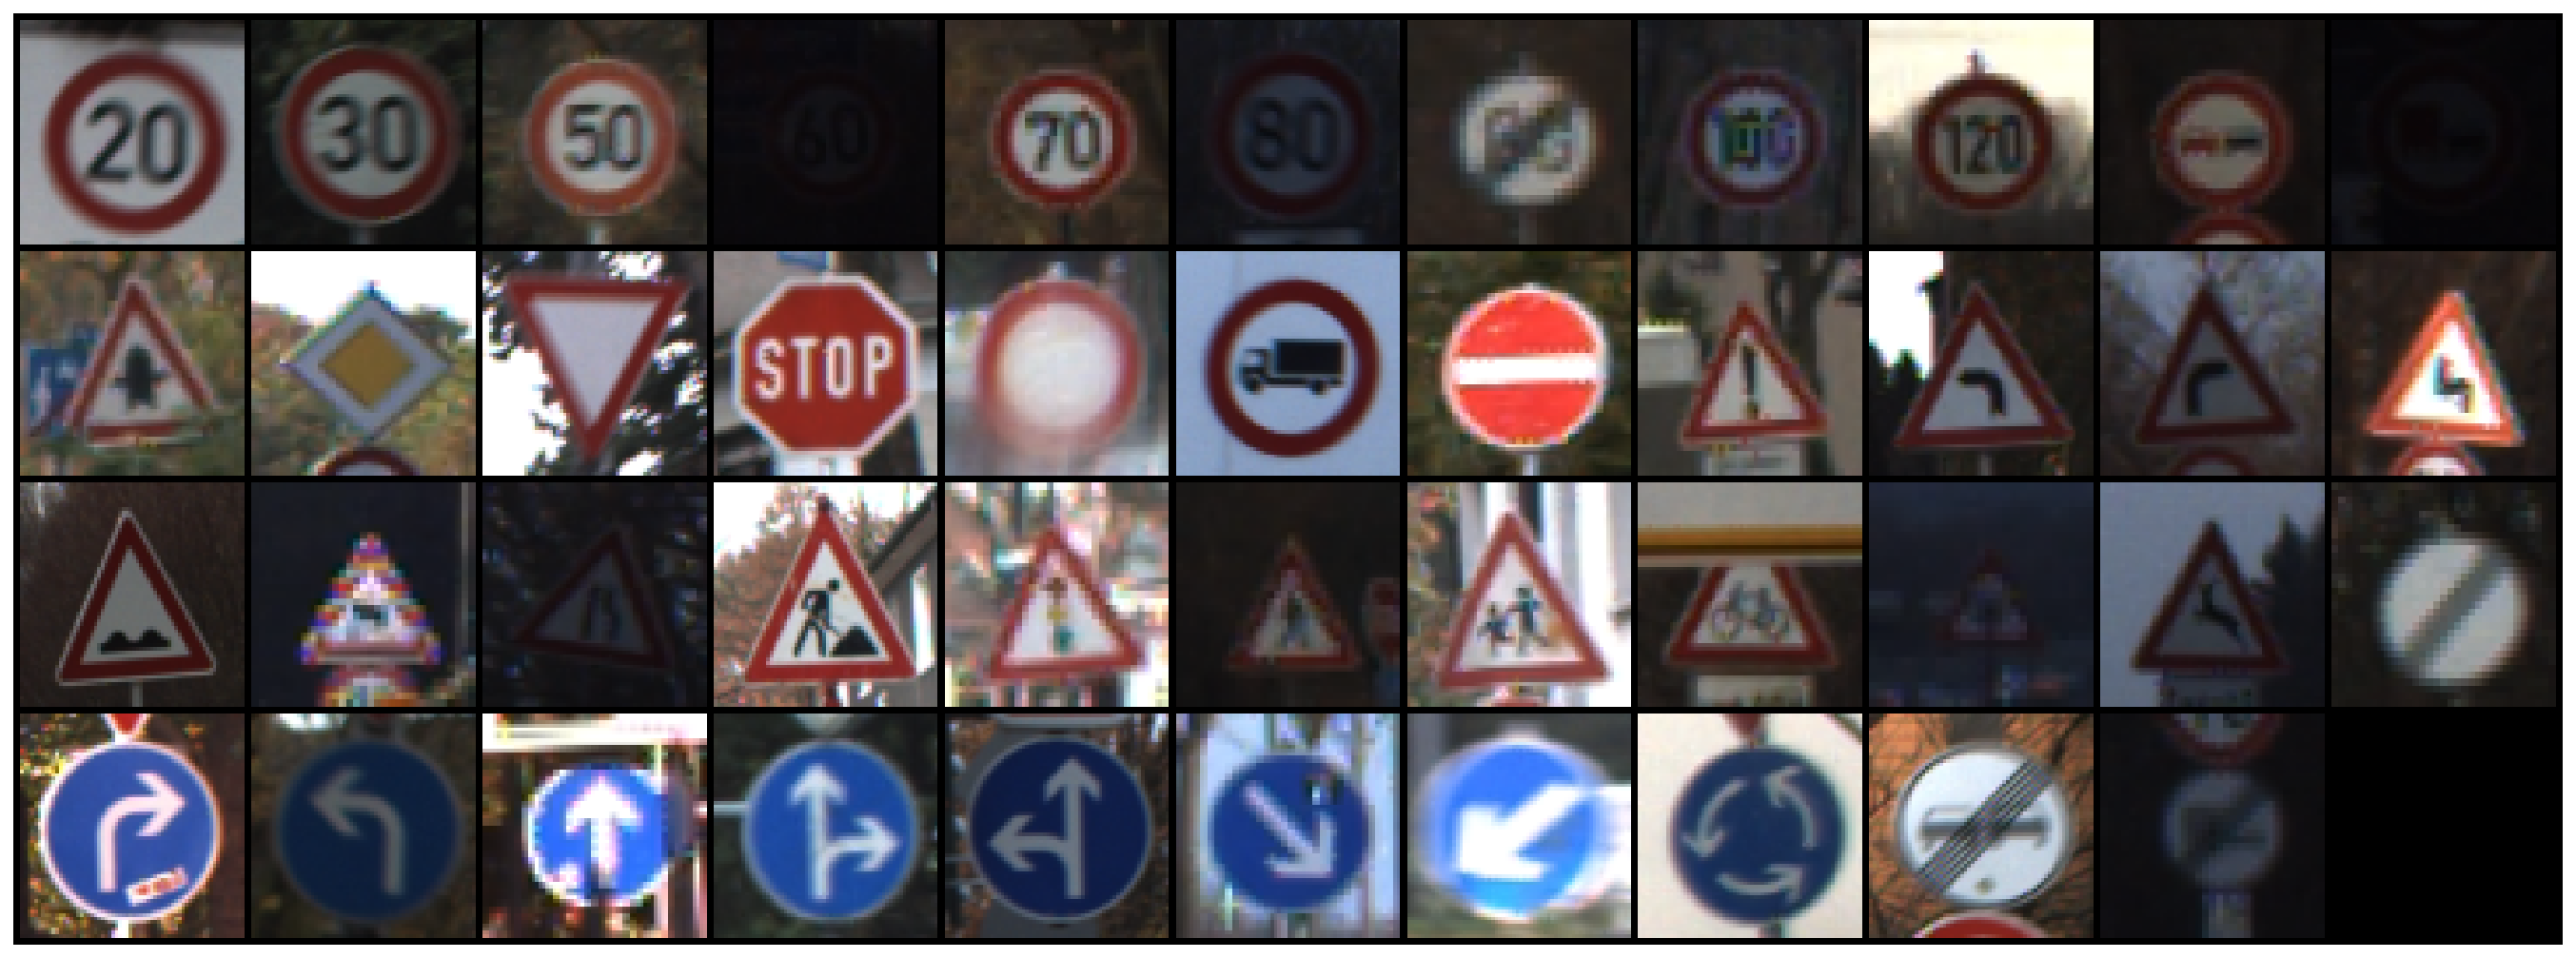

In [137]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]   #np.random.choice restituisce un elemento random dell'array
show_sign_grid(sample_images)                                                    #con f'{x}/*ppm' la stringa viene calcolara a runtime 

Singola immagine

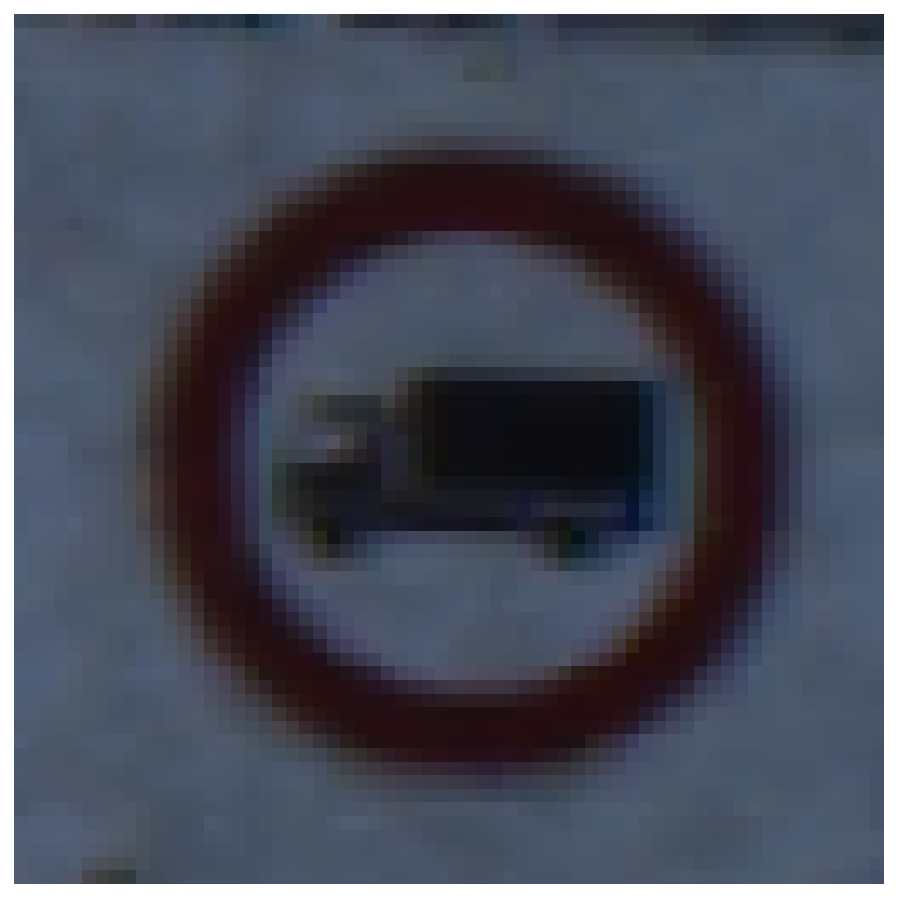

In [138]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building dataset


In [139]:
'''class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [13, 14, 15, 18]'''


class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 
    'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 
    'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
    'Speed limit (120km/h)', 'No passing', 
    'No passing for vehicles over 3.5 metric tons', 
    'Right-of-way at the next intersection', 'Priority road', 'Yield (give_way)', 
    'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 
    'No entry', 'General caution', 'Dangerous curve to the left', 
    'Dangerous curve to the right', 'Double curve', 'Bumpy road', 
    'Slippery road', 'Road narrows on the right', 'Road work', 
    'Traffic signals', 'Pedestrians', 'Children crossing', 
    'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 
    'End of all speed and passing limits', 'Turn right ahead', 
    'Turn left ahead', 'Ahead only', 'Go straight or right', 
    'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 
    'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']

class_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                 41, 42]


copia immagini nelle directory per ogni classe (semplifica torchvision's dataset helper)

In [140]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

**80% training, 10% validation, 10% test per ogni classe** (Nella corrispettiva cartella)

In [141]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')   # Copy the content of source to destination

Speed limit (20km/h): 210
Speed limit (30km/h): 2220
Speed limit (50km/h): 2250
Speed limit (60km/h): 1410
Speed limit (70km/h): 1980
Speed limit (80km/h): 1860
End of speed limit (80km/h): 420
Speed limit (100km/h): 1440
Speed limit (120km/h): 1410
No passing: 1470
No passing for vehicles over 3.5 metric tons: 2010
Right-of-way at the next intersection: 1320
Priority road: 2100
Yield (give_way): 2160
Stop: 780
No vehicles: 630
Vehicles over 3.5 metric tons prohibited: 420
No entry: 1110
General caution: 1200
Dangerous curve to the left: 210
Dangerous curve to the right: 360
Double curve: 330
Bumpy road: 390
Slippery road: 510
Road narrows on the right: 270
Road work: 1500
Traffic signals: 600
Pedestrians: 240
Children crossing: 540
Bicycles crossing: 270
Beware of ice/snow: 450
Wild animals crossing: 780
End of all speed and passing limits: 240
Turn right ahead: 689
Turn left ahead: 420
Ahead only: 1200
Go straight or right: 390
Go straight or left: 210
Keep right: 2070
Keep left: 300

##Il dataset è sbilanciato, applico trasformazioni per **"Augmentation"**

In [142]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=20),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Cereo dataset PyTorch per ogni "image dataset folder" e "data loaders" per semplificare training


In [143]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Salvo numero di example e nome delle classi in ogni dataset

In [144]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 3921, 'train': 31367, 'val': 3921}



Visualizza immagini dopo trasformazioni (reverse della normalizzazione e dei canali colore)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


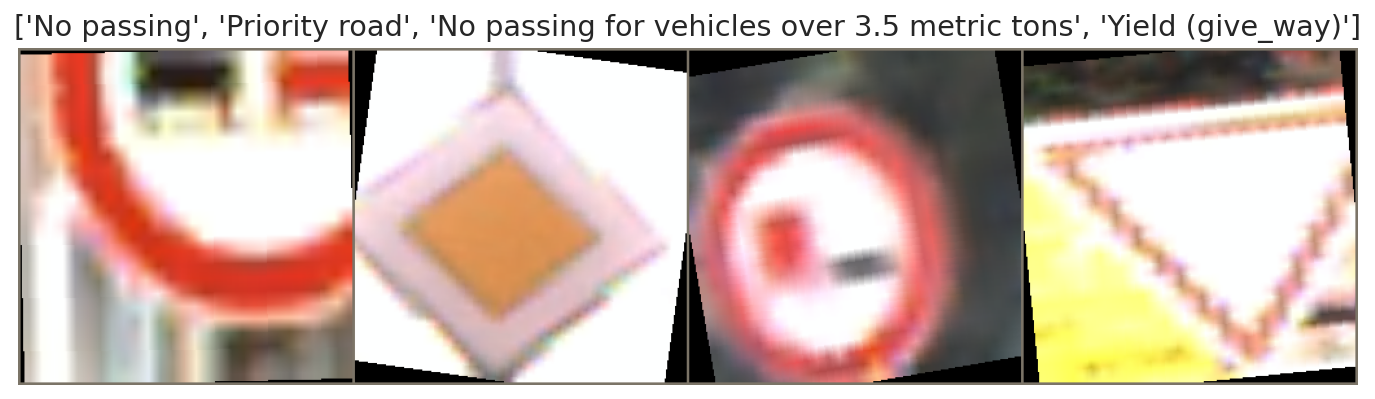

In [145]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creo Modello
(Più modelli in base all'input per confronto)

Il layer di output deve essere sostituito per combaciare con il numero di output ed essere addestrato

In [168]:
def create_model(net_model, n_classes):
  if(net_model=='resnet18'):
    model = models.resnet18(pretrained=False)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model == 'googleLeNet'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='mobilenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, n_classes)

  if(net_model=='mobilenet_v3'):
    model = models.mobilenet_v3_small(pretrained=True, progress=True)
    model.classifier[-1] = nn.Linear(1024, n_classes)

  if(net_model == 'efficientnet_b0'):
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes)

    #model = models.mobilenet_v3_small(pretrained=True, progress=True)
    #print(model.classifier)

  return model.to(device)

### Training
Modello in train-mode. Si cicla sugli input e le lora label, si ottiene la predizione (classe con max prob) e si calcola loss ed accuracy

In [147]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  
  #Calcolo gradiente attivo
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()
  accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)

##Evaluating
Simile al training ma effettuato sul validation per verificare il modello e non calcola gradiente

In [148]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  #Calcolo gradiente inattivo
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)


##Training completo

L'History salva le performance, pytorch salva il "miglior modello" ed i suoi pesi ottenuti durante il training

In [149]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=2):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss}  accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss}  accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      #Salvataggio
      torch.save(model.state_dict(), 'best_model_resnet18.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_resnet18.bin'))
  print("Model saved")

  return model, history


Scelta e training del modello:

##ResNet18

In [170]:
base_model = create_model('resnet18',len(class_names))

#comando time restituisce wall time della cella

In [171]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 2.63952289202085  accuracy 0.250549941020818
Val   loss 1.6010889653422633  accuracy 0.47028819178780923

Epoch 2/2
----------
Train loss 1.5776744034278827  accuracy 0.520260146013326
Val   loss 0.795760190281229  accuracy 0.7383320581484315

Best val accuracy: 0.7383320581484315
Model saved
CPU times: user 6min 41s, sys: 23.6 s, total: 7min 5s
Wall time: 7min 32s


##GoogleLeNet

In [ ]:
%%time
base_model = create_model('googleLeNet', len(class_names))


base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

##MobileNet_v2

In [ ]:
%%time
base_model = create_model('mobilenet_v2', len(class_names))


base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.1226563766851574 accuracy 0.6854656167309592
Val   loss 0.15784184046297497 accuracy 0.9426166794185157

Epoch 2/10
----------
Train loss 0.5632292804628534 accuracy 0.8345394841712627
Val   loss 0.12485292850065972 accuracy 0.9525631216526396

Epoch 3/10
----------
Train loss 0.48259399302943773 accuracy 0.8531258966429687
Val   loss 0.07546369008892014 accuracy 0.9709257842387146

Epoch 4/10
----------
Train loss 0.43091367215613136 accuracy 0.8696081869480664
Val   loss 0.10837625781485341 accuracy 0.9642948227492986

Epoch 5/10
----------
Train loss 0.38338002735183535 accuracy 0.8792042592533553
Val   loss 0.09947126788758237 accuracy 0.9655700076511093

Epoch 6/10
----------
Train loss 0.3676249196344899 accuracy 0.8837631906143398
Val   loss 0.10780033844193883 accuracy 0.9673552665136445

Epoch 7/10
----------
Train loss 0.3419428331340252 accuracy 0.8933273822807408
Val   loss 0.07413136968362337 accuracy 0.9747513389441469

Epoch 8/10
----------
Train loss 0.2711

##MobileNet_v3

In [ ]:
%%time
base_model = create_model('mobilenet_v3', len(class_names))

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.0805101371497479 accuracy 0.6898332642586157
Val   loss 0.22283515037644444 accuracy 0.9229788319306299

Epoch 2/10
----------
Train loss 0.5164471083554306 accuracy 0.8415851053655115
Val   loss 0.15746903121413047 accuracy 0.9433817903596021

Epoch 3/10
----------
Train loss 0.4157773616441435 accuracy 0.8714253833646826
Val   loss 0.07861439861987549 accuracy 0.9704157102779902

Epoch 4/10
----------
Train loss 0.37655346522257 accuracy 0.8835081455032358
Val   loss 0.08704853138742907 accuracy 0.968375414435093

Epoch 5/10
----------
Train loss 0.33802907051220393 accuracy 0.8916377084196766
Val   loss 0.07521693479121326 accuracy 0.9729660800816118

Epoch 6/10
----------
Train loss 0.31656993942525247 accuracy 0.9009149743360856
Val   loss 0.06048644100365231 accuracy 0.9778117827084927

Epoch 7/10
----------
Train loss 0.3091476720002368 accuracy 0.9040073963082219
Val   loss 0.049150448549182865 accuracy 0.981637337413925

Epoch 8/10
----------
Train loss 0.25938292

##EfficientNet_b0

In [ ]:
%%time
base_model = create_model('efficientnet_b0', len(class_names))

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.1687184989806447 accuracy 0.6814805368699588
Val   loss 0.21780703657135575 accuracy 0.9347105330272889

Epoch 2/10
----------
Train loss 0.45475390333374205 accuracy 0.865782510281506
Val   loss 0.07852566622862317 accuracy 0.9701606732976281

Epoch 3/10
----------
Train loss 0.3626545173538461 accuracy 0.8889597347530843
Val   loss 0.08269198887862811 accuracy 0.9637847487885743

Epoch 4/10
----------
Train loss 0.309161176568503 accuracy 0.904963815474862
Val   loss 0.048815607580320594 accuracy 0.9818923743942871

Epoch 5/10
----------
Train loss 0.2908415166466175 accuracy 0.9098415532247265
Val   loss 0.050283476307567264 accuracy 0.9790869676103034

Epoch 6/10
----------
Train loss 0.2748008957245149 accuracy 0.914496126502375
Val   loss 0.0435023686481475 accuracy 0.984952818158633

Epoch 7/10
----------
Train loss 0.2709339224056683 accuracy 0.9154525456690151
Val   loss 0.04928778683693744 accuracy 0.9813823004335628

Epoch 8/10
----------
Train loss 0.2746361116

NameError: ignored

##Visualizzazione History

In [172]:
def plot_training_history(history):
  #device = torch.device("cpu")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  #print("Sono qui")
  ax2.plot(history['val_acc'], label='validation accuracy')
  
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

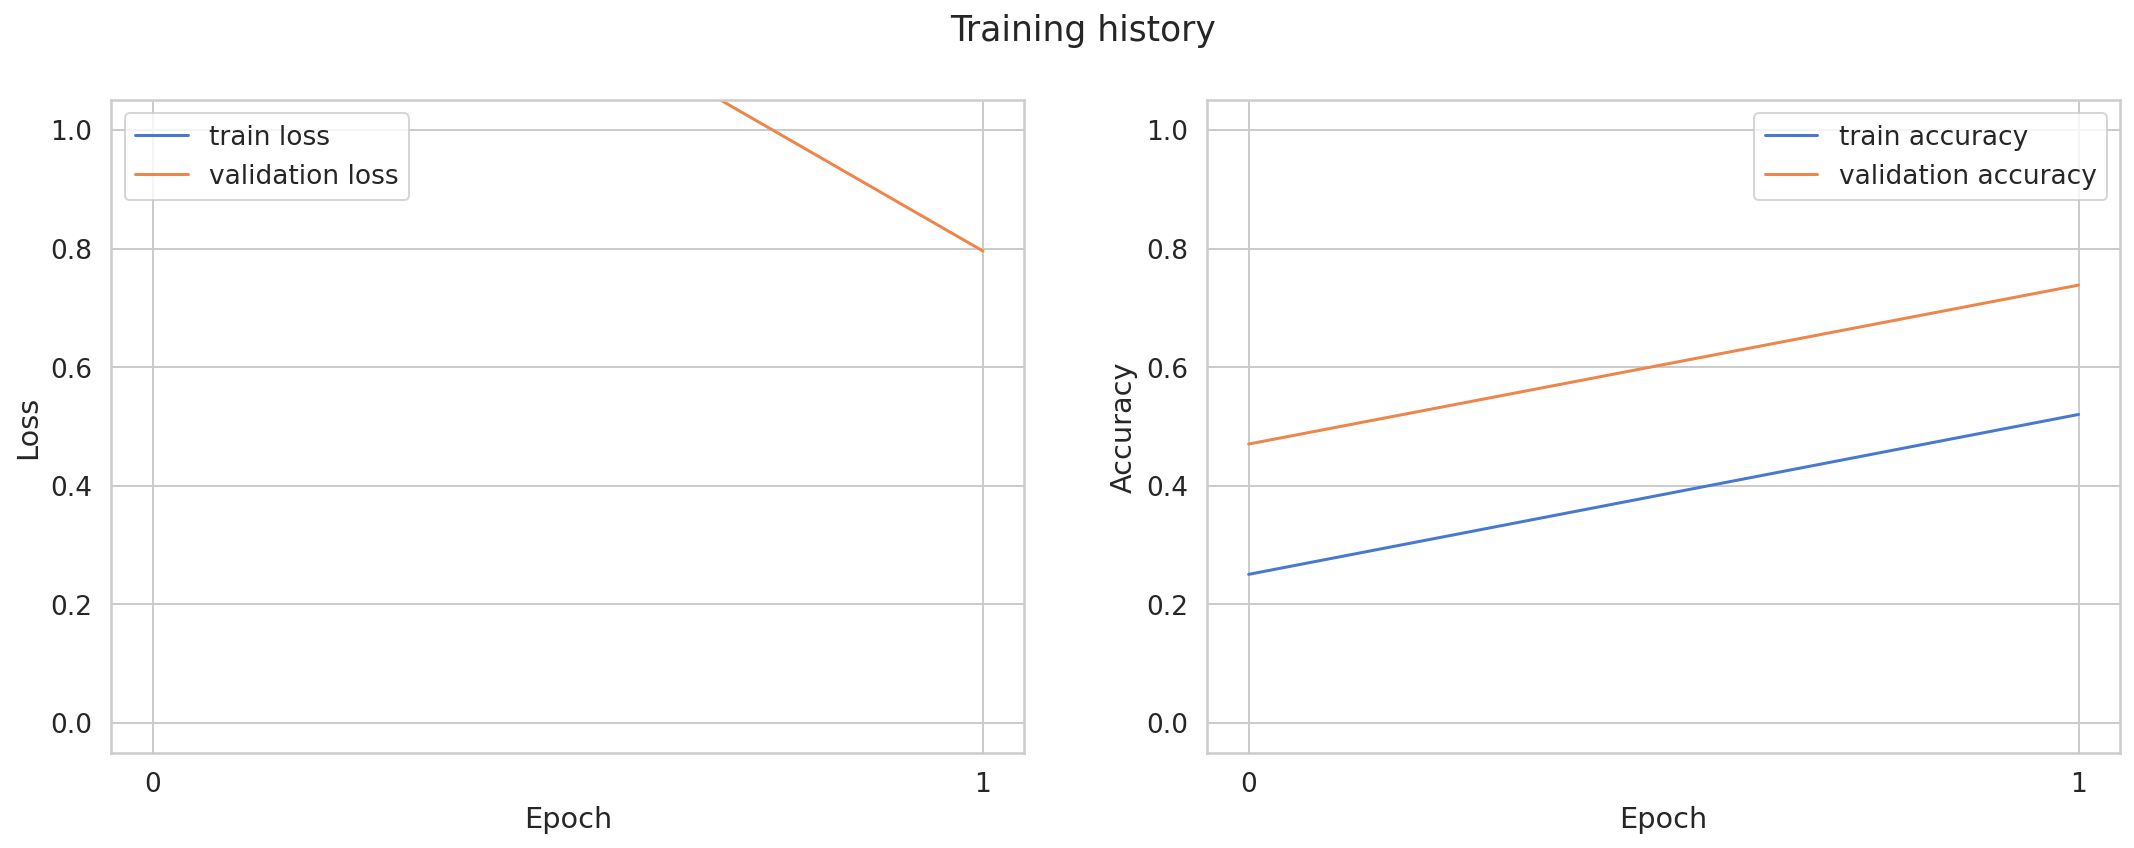

In [173]:
plot_training_history(history)


### Evaluation

Valutazione del modello sul TestSet. (No calcolo gradiente)

In [174]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


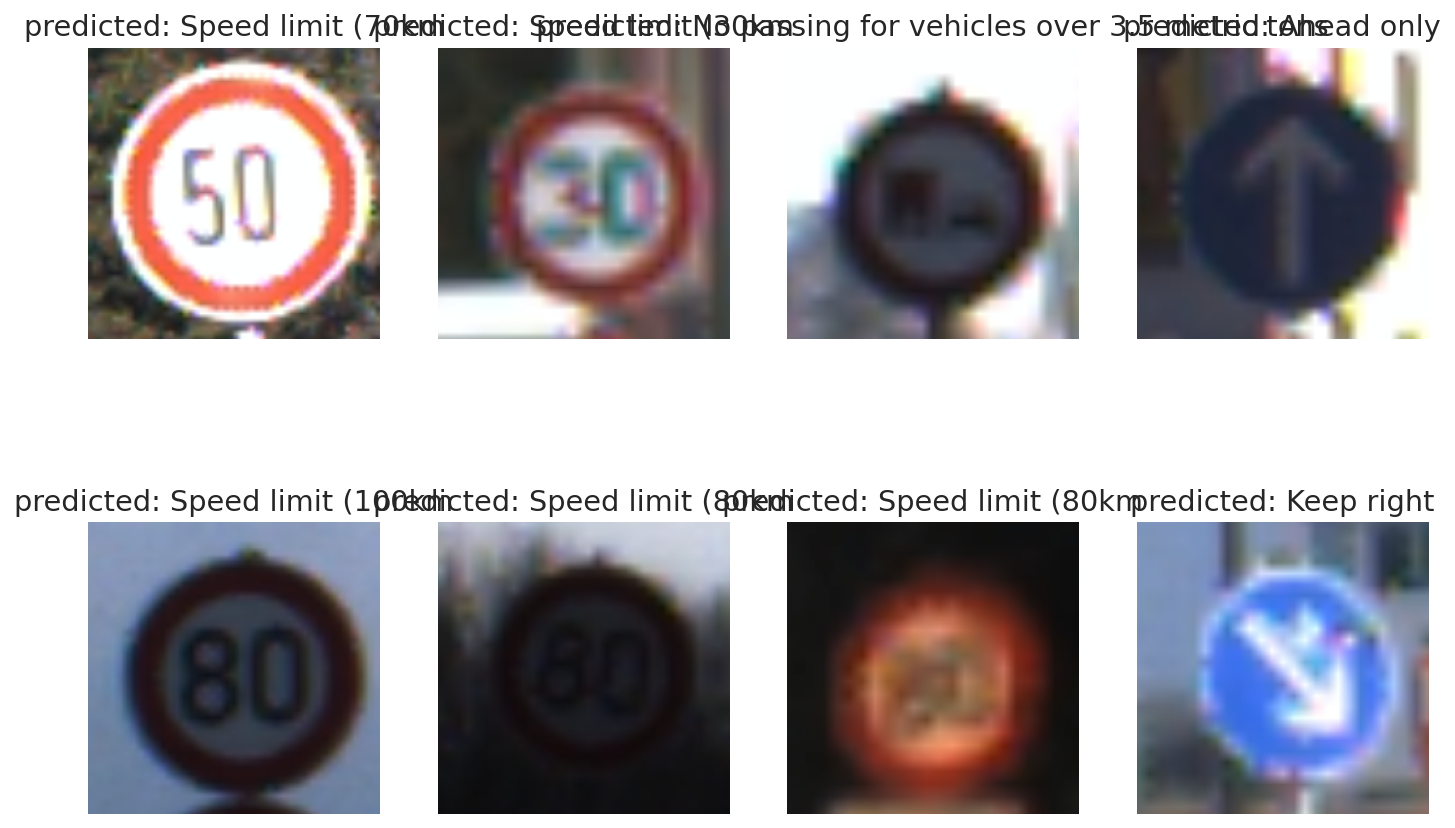

In [175]:
show_predictions(base_model, class_names, n_images=8)

In [176]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [177]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])
#print(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [178]:
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:",accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print()
'''def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

print("Accuracy: .3f", )
from sklearn.metrics import accuracy_score
print('Test accuracy: ',accuracy_score(labels, classes_x)*100)'''

                                                    precision    recall  f1-score   support

                                        Ahead only       0.83      0.91      0.87       120
                                     Beware of ice       0.74      0.64      0.69        45
                                 Bicycles crossing       1.00      0.30      0.46        27
                                        Bumpy road       0.97      0.92      0.95        39
                                 Children crossing       0.32      0.15      0.20        54
                       Dangerous curve to the left       0.67      0.10      0.17        21
                      Dangerous curve to the right       1.00      0.06      0.11        36
                                      Double curve       0.20      0.03      0.05        33
               End of all speed and passing limits       0.86      0.25      0.39        24
                                 End of no passing       0.62      0.62      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'def calculate_accuracy(y_pred, y):\n    top_pred = y_pred.argmax(1, keepdim = True)\n    correct = top_pred.eq(y.view_as(top_pred)).sum()\n    acc = correct.float() / y.shape[0]\n    return acc\n\nprint("Accuracy: .3f", )\nfrom sklearn.metrics import accuracy_score\nprint(\'Test accuracy: \',accuracy_score(labels, classes_x)*100)'

##Confusion Matrix
Visualizzazione più significativa rispetto all'accuracy delle performance 

In [222]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  #plt.figure(figsize = (10,7))
  #plt.figure(figsize=(60, 40), dpi=90)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues", annot_kws={'fontsize':5})
  #hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');
  

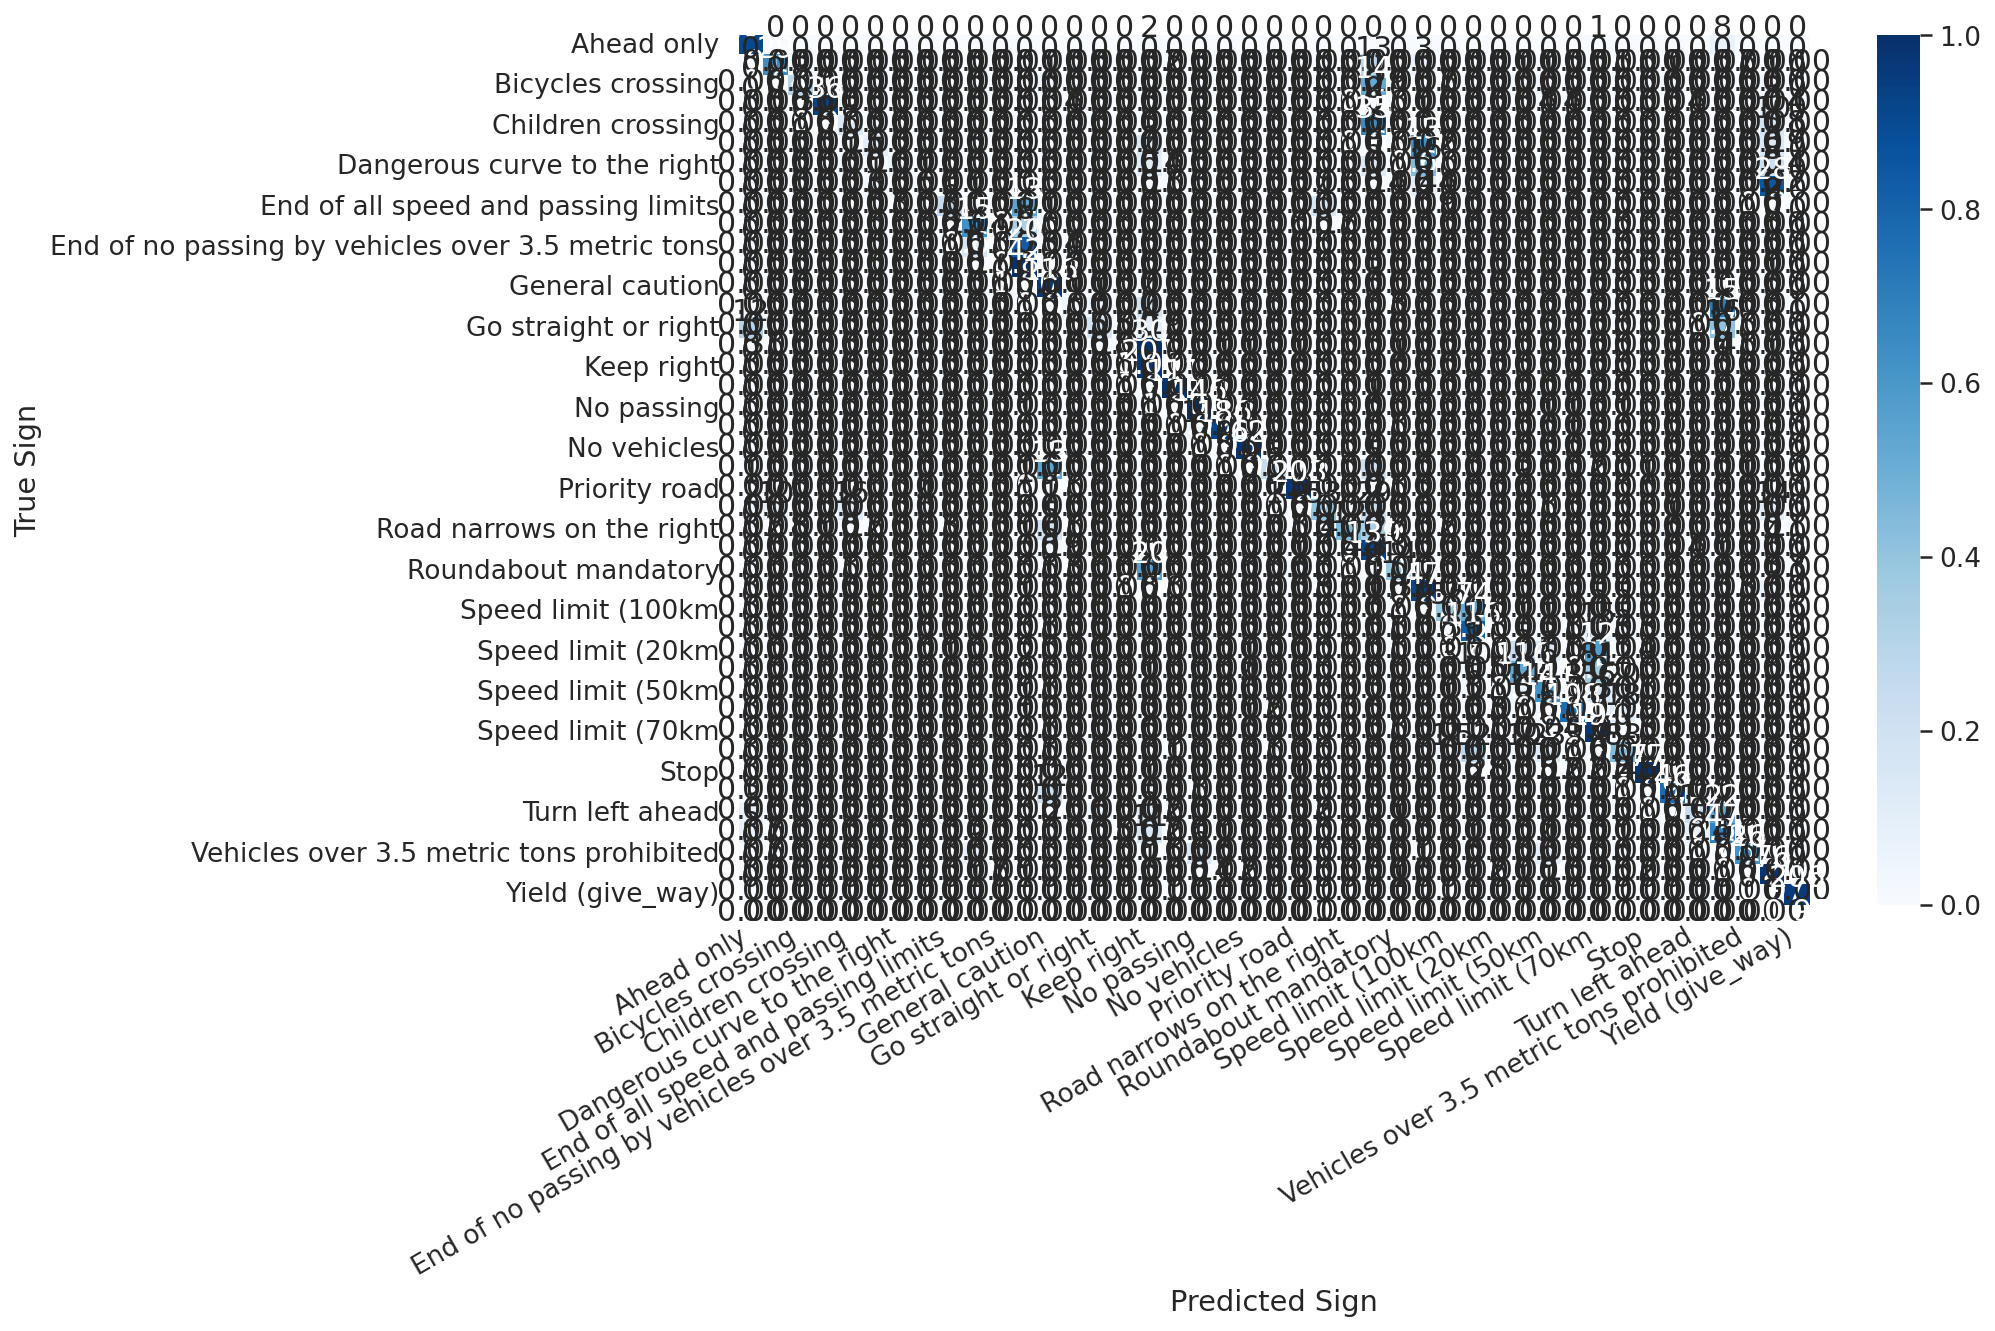

In [221]:
cm = confusion_matrix(y_test, y_pred)

show_confusion_matrix(cm, class_names)

### Classificazione immagine non vista


In [181]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 53.9MB/s]


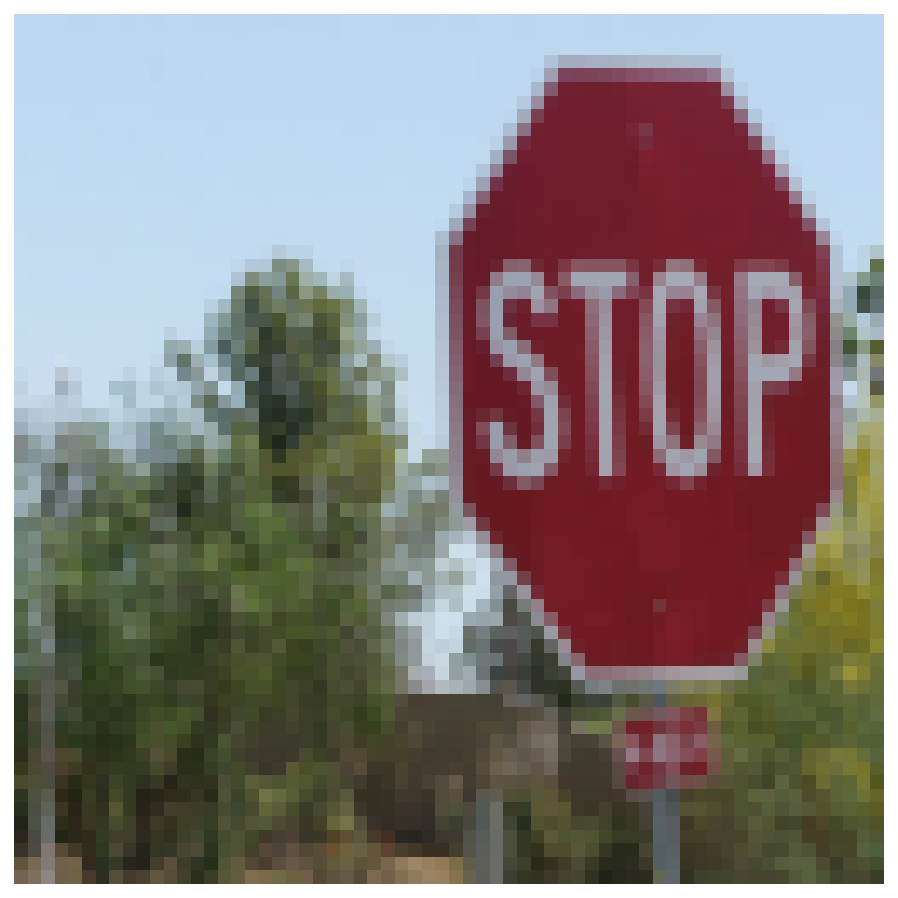

In [182]:
show_image('stop-sign.jpg')

Predizione con confidenza rispetto a tutte le classi possibili

In [183]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [184]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([1.4140891e-03, 1.3040953e-03, 3.6550199e-03, 3.0496603e-04,
       2.4418436e-02, 7.2068552e-04, 1.7954182e-04, 8.1916964e-03,
       3.6700967e-05, 2.4755948e-04, 1.2420419e-04, 1.0844383e-04,
       3.3366885e-03, 1.1634575e-03, 2.5041064e-03, 2.0254015e-04,
       5.3799496e-04, 3.5906922e-02, 1.2799699e-03, 5.1367017e-03,
       1.7862409e-04, 4.7689523e-03, 4.8717940e-03, 9.1399074e-02,
       2.1153500e-03, 2.2656421e-01, 4.9424460e-03, 1.0487848e-03,
       2.4916774e-03, 1.6041854e-03, 1.4677167e-02, 1.1076642e-01,
       4.5501783e-02, 6.7352648e-03, 2.1033797e-03, 3.4001975e-03,
       3.5123128e-01, 4.2720890e-04, 4.8240554e-04, 8.2810887e-04,
       4.4214967e-04, 9.6764641e-05, 3.2548957e-02], dtype=float32)

Plot confidenza

In [185]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

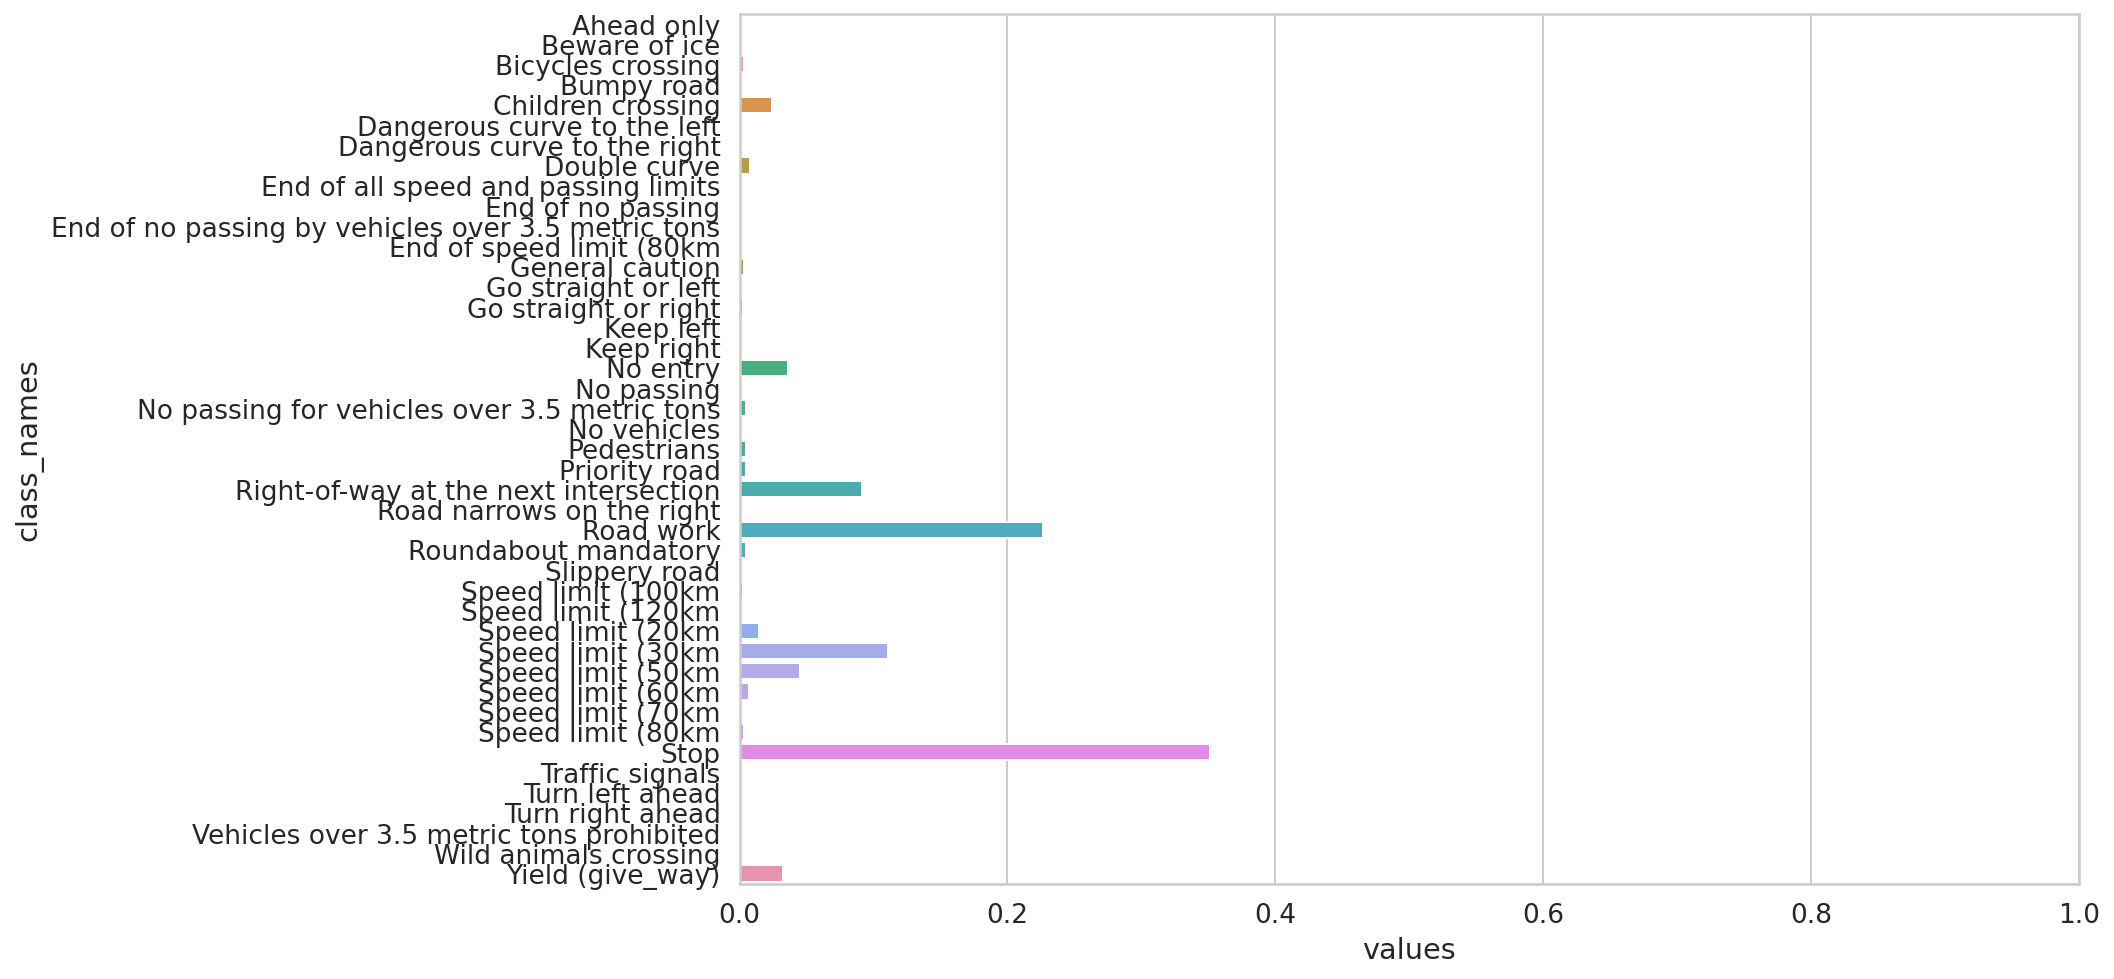

In [186]:
show_prediction_confidence(pred, class_names)